In [83]:
import random
from royalur import Game
from royalur.model.player import PlayerType
from royalur.lut.board_encoder import SimpleGameStateEncoding
from huggingface_hub import hf_hub_download
from royalur import LutAgent
import os

encoding = SimpleGameStateEncoding()
REPO_ID = "sothatsit/RoyalUr"
FILENAME = "finkel.rgu"
filename = hf_hub_download(
    repo_id=REPO_ID, filename=FILENAME, cache_dir=os.getenv("HF_CACHE_DIR", None)
)
lut_player = LutAgent(filename)
lut = lut_player.lut


def lut_get_value(game_state, get_for_player):
    if game_state.is_finished():
        value = 0 if game_state.get_winner() == PlayerType.DARK else 65535
    else:
        if game_state.get_turn() == PlayerType.DARK:
            game_state = game_state.copy_inverted()
        assert game_state.get_turn() == PlayerType.LIGHT
        value = lut.lookup(0, encoding.encode_game_state(game_state))
    if get_for_player == PlayerType.DARK:
        value = 65535 - value
    return value / 65535


def get_all_possible_moves_of_all_possible_rolls(game: Game):
    player_of_interest = game.get_turn()
    all_possible_moves_of_all_possible_rolls = {}
    for dice in range(5):
        all_possible_moves_of_all_possible_rolls[dice] = []
        game_copy = game.copy()
        game_copy.roll_dice(dice)
        if game_copy.is_waiting_for_roll():
            lut_value = lut_get_value(game_copy.get_current_state(), player_of_interest)
            # no possible moves, put score of the new state after no moves
            all_possible_moves_of_all_possible_rolls[dice].append({"score": lut_value, "dice": dice})
            continue

        for move in game_copy.find_available_moves():
            game_copy_copy = game_copy.copy()
            game_copy_copy.make_move(move)
            lut_value = lut_get_value(game_copy_copy.get_current_state(), player_of_interest)
            # Since score is for current player and the player changes after a move, invert the score of the other player
            all_possible_moves_of_all_possible_rolls[dice].append({"score": lut_value, "dice": dice})
        assert len(all_possible_moves_of_all_possible_rolls[dice]) > 0

    return all_possible_moves_of_all_possible_rolls


def compute_dice_luck_metric(rolled_dice, all_possible_moves_of_all_possible_rolls):
    # pick the best/worst possible move score in all_possible_moves_of_all_possible_rolls
    best_by_dice = {
        dice: max(all_possible_moves_of_all_possible_rolls[dice], key=lambda x: x["score"])
        for dice in all_possible_moves_of_all_possible_rolls
    }
    # pick the best of the best dice
    best_roll = max(best_by_dice.values(), key=lambda x: x["score"])
    best_score = best_roll["score"]
    # pick the worst of the best dice
    worst_roll = min(best_by_dice.values(), key=lambda x: x["score"])
    worst_score = worst_roll["score"]
    
    return (best_by_dice[rolled_dice]["score"] - worst_score) / (best_score - worst_score)



def compute_move_quality_metric(game: Game, moves, picked_move):
    if len(moves) <= 1:
        return None
    player_of_interest = game.get_turn()
    move_score_map = {}
    for move in moves:
        game_copy = game.copy()
        game_copy.make_move(move)
        lut_value = lut_get_value(game_copy.get_current_state(), player_of_interest)
        move_score_map[move] = lut_value
    
    best_move = max(move_score_map.items(), key=lambda x: x[1])
    best_score = best_move[1]
    # pick the worst of the best dice
    worst_move = min(move_score_map.items(), key=lambda x: x[1])
    worst_score = worst_move[1]
    if best_score == worst_score:
        return None
    #print(move_score_map)
    #print(best_score, worst_score, move_score_map[picked_move])
    #print(score)
    return (move_score_map[picked_move] - worst_score) / (best_score - worst_score)

all_skill_points = []
all_luck_points = []
n_skill_zero = 0
n_luck_one = 0
total = 0
total_luck = 0

def _play_randomly(game: Game):
    global total, n_skill_zero, n_luck_one, total_luck
    skill_points = []
    luck_points = []
    while not game.is_finished():
        if game.is_waiting_for_roll():
            all_possibilities = get_all_possible_moves_of_all_possible_rolls(game)
            #print(all_possibilities)
            roll = game.roll_dice()
            # compute dice luck metric
            dice_luck_metric = compute_dice_luck_metric(roll.value, all_possibilities)
            total_luck += 1
            if dice_luck_metric is not None:
                luck_points.append(dice_luck_metric)
                if dice_luck_metric == 1:
                    n_luck_one += 1
            #print(f"Rolled: {roll.value}, dice luck metric: {dice_luck_metric}")
        else:
            moves = game.find_available_moves()
            move = moves[random.randint(0, len(moves) - 1)]
            skill_metric = compute_move_quality_metric(game, moves, move)
            total += 1
            if skill_metric is not None:
                skill_points.append(skill_metric)
                if skill_metric == 0:
                    n_skill_zero += 1
            #print(skill_metric)
            # compute move quality metric
            game.make_move(move)

    all_skill_points.extend(skill_points)
    all_luck_points.extend(luck_points)
    print(f"Skill: {sum(skill_points) / len(skill_points)}")
    print(f"Luck: {sum(luck_points) / len(luck_points)}")

for i in range(100):
    game = Game.create_finkel()
    _play_randomly(game)

Skill: 0.5598151253836232
Luck: 0.6424844351285134
Skill: 0.44052228083086437
Luck: 0.5273232128631037
Skill: 0.5779300491624182
Luck: 0.5965887096614961
Skill: 0.46314865829580726
Luck: 0.459592621600664
Skill: 0.47771721199915723
Luck: 0.5716515858657832
Skill: 0.5699611834777175
Luck: 0.5424623705096597
Skill: 0.502335545649106
Luck: 0.5859835677844724
Skill: 0.38757383478985363
Luck: 0.5114573117749844
Skill: 0.45256158273279024
Luck: 0.4711732070649696
Skill: 0.4390829024796572
Luck: 0.49731688549867437
Skill: 0.39465360309942843
Luck: 0.46896086851908797
Skill: 0.5666959717758752
Luck: 0.5004787148798285
Skill: 0.5045954235737997
Luck: 0.5531440400896475
Skill: 0.5431129151680157
Luck: 0.5588731639306702
Skill: 0.5564220567890472
Luck: 0.5386273156605632
Skill: 0.4899674817798209
Luck: 0.5521020314518423
Skill: 0.46193435849389947
Luck: 0.5415903176778173
Skill: 0.5740456751102606
Luck: 0.5566868162572906
Skill: 0.5116109935530667
Luck: 0.6119016057739821
Skill: 0.467254972386414

In [77]:
n_skill_zero, total

(4669, 14761)

In [84]:
n_luck_one, total_luck

(2876, 15534)

In [85]:
import pandas as pd

skill_series = pd.Series(all_skill_points)
luck_series = pd.Series(all_luck_points)

<Axes: >

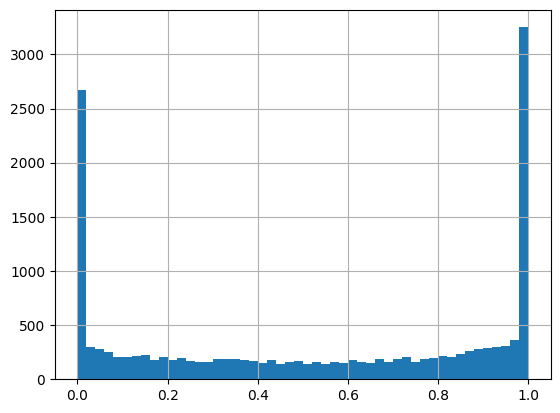

In [90]:
luck_series.hist(bins=50)

<Axes: >

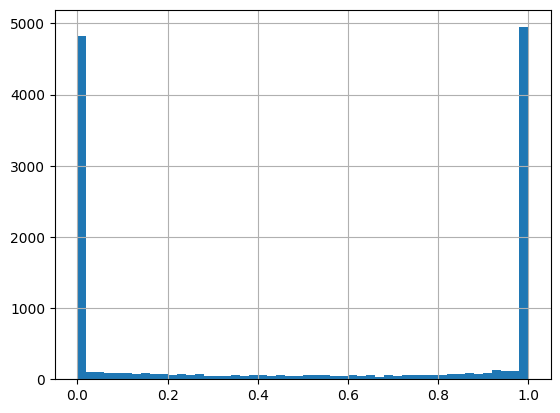

In [82]:
skill_series.hist(bins=50)